In [55]:
import random
from simprocess import ProcessDataLoader, Simulation
import numpy as np
import time
import math
from typing import List

def get_action_from_int(int_action_value, nmb_of_tasks):
    """
    :param nmb_of_tasks: number of tasks
    :param nmb_of_resources: number of resources
    :param int_action_value: action value from the range NxM where N - nmb_of_resources, M - nmb_of_tasks
    :return: [resource, task] Vector of length 2 of actions to be taken by the environment
    """
    if int_action_value == 0:
        return [-1, -1]
    else:
        action_coded_value = int_action_value - 1
        resource = math.floor(action_coded_value / nmb_of_tasks)
        task = action_coded_value % nmb_of_tasks
        return [resource, task]

In [56]:
loader = ProcessDataLoader("./conf/simulation_config.json", "./conf/resource_eligibility.json")
processes = loader.load_process_data()
available_resources = loader.load_available_resources()
process_case_probability = loader.load_process_case_probability()
queue_duration_limit = loader.load_queue_capacity_modifier()
simulation = Simulation(available_resources, processes, process_case_probability, 1, queue_duration_limit, "a2")
NO_EPISODES = 100

In [57]:
def test_method(method: str, simulation=simulation, steps_per_episode=400) -> List[int]:
    action_space = simulation.action_space
    rewards = []
    start_time = time.time()
    for episode in range(NO_EPISODES):
        reward_sum = 0
        state = simulation.reset()
        for step in range(steps_per_episode):
            action = np.random.randint(action_space[0] * action_space[1] + 1)
            action = get_action_from_int(action, action_space[1])
            if method == "fifo":
                next_state, reward, action = simulation.step_fifo()
            elif method == "spt":
                next_state, reward, action = simulation.step_spt()
            else:
                print("Please specify correct algorithm SPT or FIFO")
                break
            reward_sum += reward
        rewards.append(reward_sum)
    time_method = time.time() - start_time
    return rewards, time_method

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rewards(rewards_all, method, times=None):
    episodes = list(range(100))
    rewards_all = np.array(rewards_all)

    median_rewards = np.median(rewards_all, axis=0)
    q1_rewards = np.percentile(rewards_all, 25, axis=0)
    q3_rewards = np.percentile(rewards_all, 75, axis=0)
    min_rewards = np.min(rewards_all, axis=0)
    max_rewards = np.max(rewards_all, axis=0)

    plt.figure(figsize=(12, 9))
    plt.ylim(0, 22.5)
    
    # Plot the range of values in light grey
    plt.fill_between(episodes, min_rewards, max_rewards, color='lightgrey', label='Range of reward values')

    # Plot the median values
    plt.plot(episodes, median_rewards, label='Median')
    plt.grid()
    # Plot the 1st quantile
#     plt.plot(episodes, median_rewards, label='1st quantile', color='orange')
    # Plot the 3rd quantile
#     plt.plot(episodes, median_rewards, label='3rd quantile', color='green')

    # Plot the 1st and 3rd quantiles
    plt.fill_between(episodes, q1_rewards, q3_rewards, alpha=0.3, color='orange', label='25-75 percentile')

    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title(f'Results for evaluation using {method} method')
    plt.legend()
    
    if times is not None:
        plt.text(0.05, 0.05, 'Mean running time for all episodes {}'.format(sum(times)/len(times)), transform=plt.gca().transAxes, fontsize=15, color='black')
    plt.show()

In [40]:
# SPT
rewards_all_spt = []
times_spt = []
for i in range(30):
    rewards, time = test_method("spt")
    rewards_all_spt.append(rewards)
    times_spt.append(time)

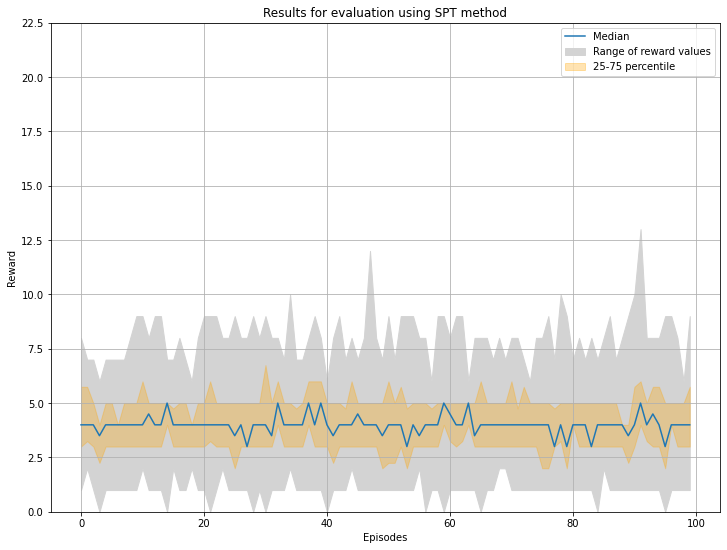

In [54]:
plot_rewards(rewards_all_spt, "SPT")

In [42]:
# FIFO
rewards_all_fifo = []
times_fifo = []
for i in range(30):
    rewards, time = test_method("fifo")
    rewards_all_fifo.append(rewards)
    times_fifo.append(time)

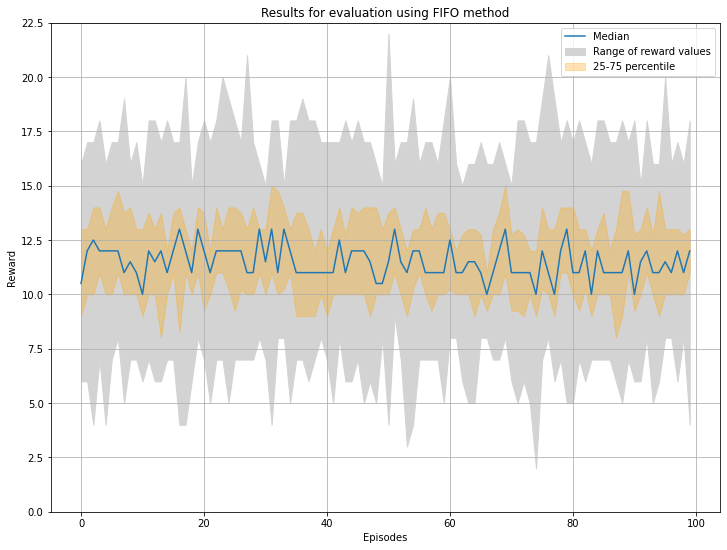

In [43]:
plot_rewards(rewards_all_fifo, "FIFO")

In [61]:
# SPT for steps per episode 5000
rewards_spt_5000, times_spt_5000 = test_method("spt", steps_per_episode=5000)
print(f"Done with SPT after {times_spt_5000}")
rewards_fifo_5000, times_fifo_5000 = test_method("fifo", steps_per_episode=5000)

Done with SPT after 519.9459636211395


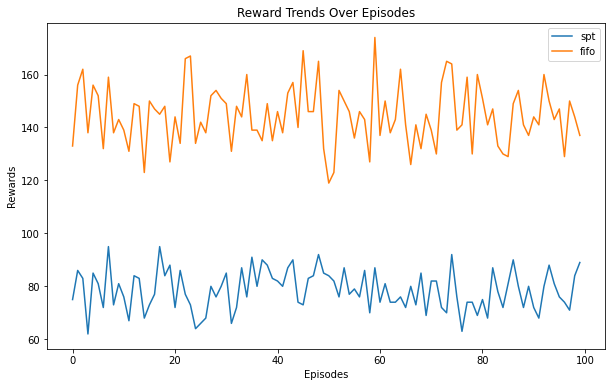

In [70]:
rewards_algos_5000 = {
    "spt":rewards_spt_5000,
    "fifo":rewards_fifo_5000
}

episodes = list(range(len(list(rewards_algos_5000.values())[0])))

plt.figure(figsize=(10, 6))

# Plotting lines for each set of rewards
for key, rewards in rewards_algos_5000.items():
    plt.plot(episodes, rewards, label=f'{key}')

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Reward Trends Over Episodes')

# Adding legend
plt.legend()

# Display the plot
plt.show()